dict_keys(['neg', 'pos', 'aty', 'sus'])
Keys in sample: dict_keys(['imgs', 'metadata'])
Shape of first image: (44, 34, 3)


/var/folders/36/5p94v0y16wzdmb1_3wfvx09m0000gn/T/ipykernel_18516/3216106709.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  specimens = pickle.load(f)


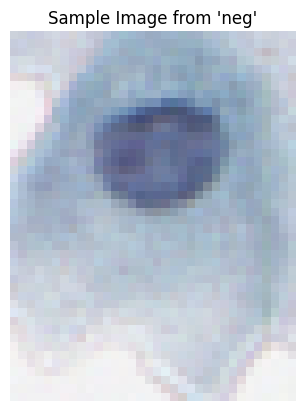

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from semseg_functions import make_predictions


# Load the pickled specimen dataset
with open("specimens_toy_data.pkl", "rb") as f:
    specimens = pickle.load(f)

print(specimens.keys())
sample = specimens["neg"]
print("Keys in sample:", sample.keys())
print("Shape of first image:", np.array(sample["imgs"][0]).shape)

plt.imshow(sample["imgs"][0])
plt.axis("off")
plt.title("Sample Image from 'neg'")
plt.show()


In [15]:
from functools import reduce
import cv2
import torch
import numpy as np

resize = lambda x: cv2.resize(x, (256, 256), interpolation=cv2.INTER_CUBIC)

all_images = reduce(lambda x, y: x + y, [list(map(resize, specimens[k]["imgs"])) for k in specimens])
all_labels = reduce(lambda x, y: x + y, [[k]*len(specimens[k]["imgs"]) for k in specimens])  

X_specimen = torch.FloatTensor(np.array(all_images) / 255.0).permute(0, 3, 1, 2)


Convert specimen images, run segmentation prediction

In [9]:
y_specimen_pred = make_predictions(
    X_specimen, 
    encoder_name="resnet34", 
    model_key="fpn"
)
y_specimen_pred_lbls = y_specimen_pred.argmax(axis=1)

print("Predicted mask shape:", y_specimen_pred_lbls.shape)

Predicted mask shape: (100, 256, 256)


Compute N/C Ratios from Predicted Masks

In [ ]:
nucleus_pixels = (y_specimen_pred_lbls == 2).sum(axis=(1, 2))  
cytoplasm_pixels = (y_specimen_pred_lbls == 1).sum(axis=(1, 2))

nc_ratios = nucleus_pixels / (nucleus_pixels + cytoplasm_pixels)

for i in range(5):
    print(f"Cell {i}: Nucleus={nucleus_pixels[i]}, Cytoplasm={cytoplasm_pixels[i]}, N/C Ratio={nc_ratios[i]:.3f}")


Cell 0: Nucleus=35007, Cytoplasm=26222, N/C Ratio=0.572
Cell 1: Nucleus=34990, Cytoplasm=26237, N/C Ratio=0.571
Cell 2: Nucleus=34989, Cytoplasm=26241, N/C Ratio=0.571
Cell 3: Nucleus=34990, Cytoplasm=26241, N/C Ratio=0.571
Cell 4: Nucleus=34998, Cytoplasm=26229, N/C Ratio=0.572


Create the DataFrame

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "nc_ratio": nc_ratios,  
    "class_": all_labels     
})

df["class_"] = pd.Categorical(df["class_"], categories=["neg", "aty", "sus", "pos"], ordered=True)

df["class_str"] = df["class_"].astype(str)

df.head()



,nc_ratio,class_,class_str
0,0.571739,neg,neg
1,0.571480,neg,neg
2,0.571436,neg,neg
3,0.571443,neg,neg
4,0.571611,neg,neg


Plot Boxplot of N/C Ratio by Class

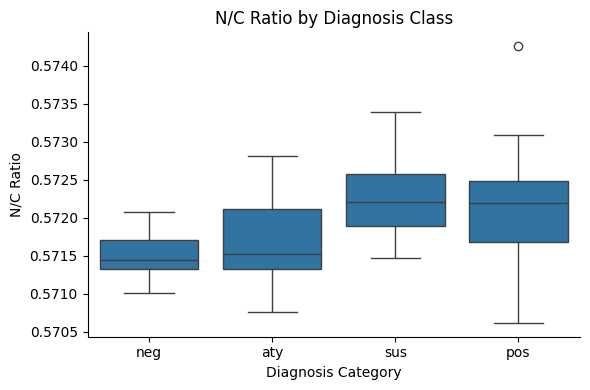

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x="class_", y="nc_ratio", data=df)
plt.title("N/C Ratio by Diagnosis Class")
plt.xlabel("Diagnosis Category")
plt.ylabel("N/C Ratio")
sns.despine()
plt.tight_layout()
plt.show()


Spearman Correlation

In [24]:
from scipy.stats import spearmanr

ordinal_classes = df["class_"].cat.codes

corr, pval = spearmanr(df["nc_ratio"], ordinal_classes)
print(f"Spearman correlation: {corr:.3f}  (p = {pval:.2e})")


Spearman correlation: 0.518  (p = 3.31e-08)


Binary Classification

In [26]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

df["binary_label"] = df["class_"].map(lambda x: 1 if x in ["sus", "pos"] else 0)

clf = LogisticRegression()
clf.fit(df["nc_ratio"].values.reshape(-1, 1), df["binary_label"])

preds = clf.predict(df["nc_ratio"].values.reshape(-1, 1))
print(classification_report(df["binary_label"], preds, target_names=["Low Risk", "High Risk"]))



              precision    recall  f1-score   support

    Low Risk       0.74      0.84      0.79        50
   High Risk       0.81      0.70      0.75        50

    accuracy                           0.77       100
   macro avg       0.78      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100



Define thresholds for risk categories and visualize

risk_score
Medium    63
Low       20
High      17
Name: count, dtype: int64


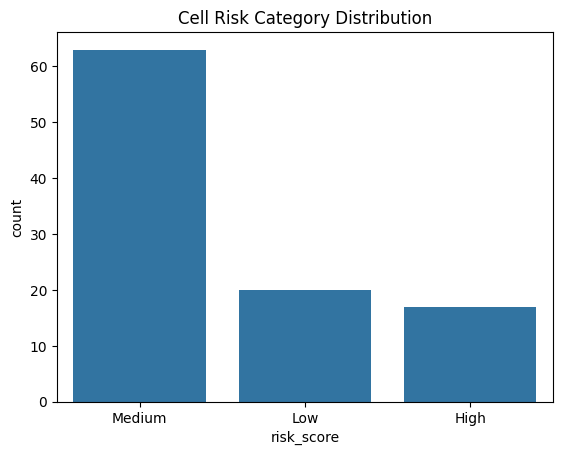

risk_score,High,Low,Medium
class_,,,
neg,0.00,0.40,0.60
aty,0.08,0.28,0.64
sus,0.36,0.00,0.64
pos,0.24,0.12,0.64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create risk category
def categorize_risk(nc):
    if nc < 0.5714:
        return "Low"
    elif nc < 0.5725:
        return "Medium"
    else:
        return "High"

df["risk_score"] = df["nc_ratio"].apply(categorize_risk)
print(df["risk_score"].value_counts())

# Visualize the risk distribution
sns.countplot(x="risk_score", data=df)
plt.title("Cell Risk Category Distribution")
plt.show()

# Evaluate Risk Scoring vs True Diagnosis
pd.crosstab(df["class_"], df["risk_score"], normalize="index")



Compare Risk Score to Diagnosis

Risk classification accuracy: 0.64
Confusion matrix:
 [[17 33]
 [ 3 47]]


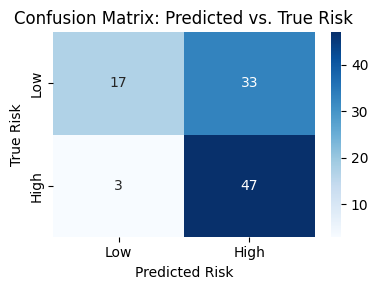

,nc_ratio,class_,true_risk,predicted_risk,correct
0,0.571739,neg,Low,High,False
1,0.571480,neg,Low,High,False
2,0.571436,neg,Low,High,False
3,0.571443,neg,Low,High,False
4,0.571611,neg,Low,High,False


In [37]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def risk_score(nc):
    if nc < 0.5714:
        return "Low"
    else:
        return "High"

df["predicted_risk"] = df["nc_ratio"].apply(risk_score)
df["true_risk"] = df["class_"].apply(lambda x: "High" if x in ["sus", "pos"] else "Low")
df["correct"] = df["predicted_risk"] == df["true_risk"]

acc = accuracy_score(df["true_risk"], df["predicted_risk"])
cm = confusion_matrix(df["true_risk"], df["predicted_risk"], labels=["Low", "High"])

print(f"Risk classification accuracy: {acc:.2f}")
print("Confusion matrix:\n", cm)

# Visualize confusion matrix heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted Risk")
plt.ylabel("True Risk")
plt.title("Confusion Matrix: Predicted vs. True Risk")
plt.tight_layout()
plt.show()

df[["nc_ratio", "class_", "true_risk", "predicted_risk", "correct"]].head()


Traditional Segmentation Comparison

In [ ]:
import numpy as np
import cv2
from skimage.color import rgb2gray
from skimage.morphology import disk, binary_opening, binary_closing
from skimage.filters import threshold_otsu
from tqdm import tqdm

traditional_nc_ratios = []

for img in tqdm(all_images):
    img_gray = rgb2gray(img)

    thresh_nucleus = threshold_otsu(img_gray)
    nucleus_mask = img_gray < thresh_nucleus * 0.95
    nucleus_mask = binary_closing(binary_opening(nucleus_mask, disk(3)), disk(5))

    cytoplasm_mask = (img_gray >= thresh_nucleus * 0.95) & (img_gray <= thresh_nucleus * 1.05)
    cytoplasm_mask = binary_closing(binary_opening(cytoplasm_mask, disk(3)), disk(5))

    nucleus_area = np.sum(nucleus_mask)
    cytoplasm_area = np.sum(cytoplasm_mask)

    if nucleus_area + cytoplasm_area > 0:
        nc_ratio = nucleus_area / (nucleus_area + cytoplasm_area)
    else:
        nc_ratio = np.nan

    traditional_nc_ratios.append(nc_ratio)


100%|██████████| 100/100 [00:01<00:00, 70.21it/s]


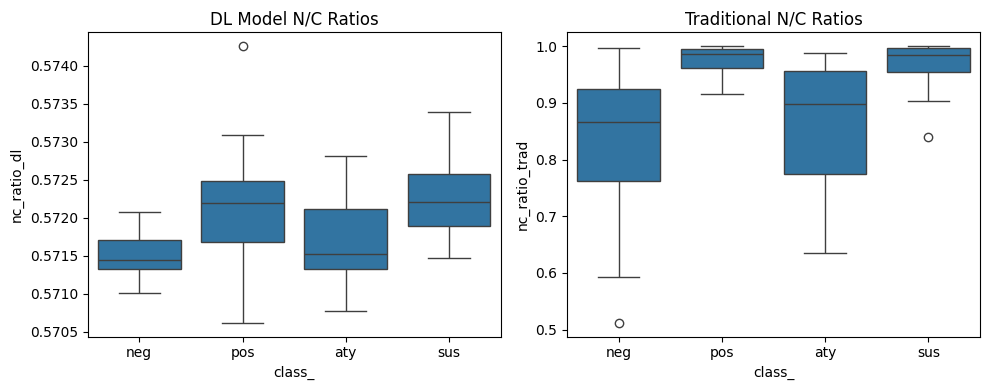

In [ ]:
df_traditional = pd.DataFrame({
    "nc_ratio_dl": df["nc_ratio"],               
    "nc_ratio_trad": traditional_nc_ratios,
    "class_": all_labels
})
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x="class_", y="nc_ratio_dl", data=df_traditional)
plt.title("DL Model N/C Ratios")

plt.subplot(1, 2, 2)
sns.boxplot(x="class_", y="nc_ratio_trad", data=df_traditional)
plt.title("Traditional N/C Ratios")

plt.tight_layout()
plt.show()

